In [13]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader

import numpy as np
from sklearn.model_selection import KFold

import argparse
import torch.optim as optim
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
import math

## Preprocessing

In [2]:
df = pd.read_csv('train.csv')

df = df.drop('X_10', axis=1)
df = df.drop('X_11', axis=1)

x_df = df.iloc[:,1:55]

scaler = MinMaxScaler()

x_scale_df = scaler.fit_transform(x_df)
input_x = torch.tensor(x_scale_df)

In [14]:
test_df = pd.read_csv('test.csv')

test_df = test_df.drop('X_10', axis=1)
test_df = test_df.drop('X_11', axis=1)

x_test_df = test_df.iloc[:,1:55]

x_test_scale_df = scaler.fit_transform(x_test_df)
test_input_x = torch.tensor(x_test_scale_df)

In [3]:
class autoencoder(nn.Module):
    def __init__(self, input_size):
        super(autoencoder,self).__init__()
        self.input_size = input_size
        
        self.input_dim = self.input_size[1]
        
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim,(self.input_dim//4)*3),
            nn.SiLU(),
            nn.Linear((self.input_dim//4)*3,(self.input_dim//4)*2),
            nn.SiLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear((self.input_dim//4)*2,(self.input_dim//4)*3),
            nn.SiLU(),
            nn.Linear((self.input_dim//4)*3,self.input_dim),
            nn.SiLU()  
        )

    def forward(self,x):
        enc_output = self.encoder(x)
        y_hat = self.decoder(enc_output)
        return y_hat

    def get_encode(self, x):
        enc_output = self.encoder(x)
        return enc_output
    

In [4]:
class tableDataset:
    def __init__(self, data):
        self.data_ = data

    def __len__(self):
        return len(self.data_)

    def __getitem__(self, idx):
        data = self.data_[idx]
        X = data
        y = data

        return X, y  ## 데이터별 리스트


In [5]:
def train(train_data, Autoencoder, Autoencoder_optimizer, args): ## Data, loss function, argument
    trainloader = DataLoader(train_data, batch_size = args.batch_size, shuffle=True, drop_last=True)
    Autoencoder.train()

    train_loss = 0.0
    for i, (x,y) in enumerate(trainloader):

        Autoencoder_optimizer.zero_grad()
        x = x.float().to(args.device)
        y = y.float().to(args.device)

        y_hat= Autoencoder(x)

        loss = args.loss_fn(y_hat,y)

        loss.backward()

        Autoencoder_optimizer.step()## parameter 갱신

        train_loss += loss.item()

    train_loss = train_loss / len(trainloader)
    return Autoencoder, train_loss



# def test(test_data, Autoencoder, Autoencoder_optimizer, args): ## Data, loss function, argument
#     testloader = DataLoader(input_x, batch_size = args.batch_size, shuffle=True, drop_last=True)
#     Autoencoder.eval()

#     test_loss = 0.0
#     with torch.no_grad():
#         for i, (x,y) in enumerate(testloader):

#             y_hat, bottlenack_vec = Autoencoder(x)

#             perc_y_pred = y_hat.cpu().detach().numpy()
#             perc_y_true = y.cpu().detach().numpy()
#             mse = mean_squared_error(y_hat, y, multioutput='raw_values')[0]
#             rmse = math.sqrt(mse)   

#             RMSE_metric += rmse
#         RMSE_metric = RMSE_metric / len(testloader)
    
#     return RMSE_metric

In [6]:
parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

args.optim = "NAdam"

args.batch_size = 128
args.lr = 0.0005
args.l2 = 0.00001

args.epoch = 100

args.loss_fn = nn.MSELoss()

In [7]:
input_size = input_x.size()

Autoencoder = autoencoder(input_size)
Autoencoder.to(args.device)


if args.optim == 'SGD':
    Autoencoder_optimizer = optim.SGD(Autoencoder.parameters(), lr=args.lr, weight_decay=args.l2)
elif args.optim == 'RMSprop':
    Autoencoder_optimizer = optim.RMSprop(Autoencoder.parameters(), lr=args.lr, weight_decay=args.l2)
elif args.optim == 'Adam':
    Autoencoder_optimizer = optim.Adam(Autoencoder.parameters(), lr=args.lr, weight_decay=args.l2)
elif args.optim == 'NAdam':
    Autoencoder_optimizer = optim.NAdam(Autoencoder.parameters(), lr=args.lr, weight_decay=args.l2)
else:
    raise ValueError('In-valid optimizer choice')



train_data = input_x

trainset = tableDataset(train_data)

train_losses = []
for epoch in range(args.epoch):

    Autoencoder,train_loss = train(trainset, Autoencoder, Autoencoder_optimizer, args)

    train_losses.append(train_loss)

    print('Epoch {}, Loss(train) {:2.5f}'.format(epoch, train_loss))

# last model save with state_dict()
torch.save(Autoencoder.state_dict(), 'Autoencoder_output' +'.pt')


Epoch 0, Loss(train) 0.04678
Epoch 1, Loss(train) 0.01408
Epoch 2, Loss(train) 0.01202
Epoch 3, Loss(train) 0.00882
Epoch 4, Loss(train) 0.00750
Epoch 5, Loss(train) 0.00699
Epoch 6, Loss(train) 0.00641
Epoch 7, Loss(train) 0.00602
Epoch 8, Loss(train) 0.00562
Epoch 9, Loss(train) 0.00523
Epoch 10, Loss(train) 0.00465
Epoch 11, Loss(train) 0.00399
Epoch 12, Loss(train) 0.00357
Epoch 13, Loss(train) 0.00335
Epoch 14, Loss(train) 0.00321
Epoch 15, Loss(train) 0.00312
Epoch 16, Loss(train) 0.00303
Epoch 17, Loss(train) 0.00295
Epoch 18, Loss(train) 0.00288
Epoch 19, Loss(train) 0.00282
Epoch 20, Loss(train) 0.00276
Epoch 21, Loss(train) 0.00271
Epoch 22, Loss(train) 0.00264
Epoch 23, Loss(train) 0.00259
Epoch 24, Loss(train) 0.00253
Epoch 25, Loss(train) 0.00248
Epoch 26, Loss(train) 0.00241
Epoch 27, Loss(train) 0.00232
Epoch 28, Loss(train) 0.00220
Epoch 29, Loss(train) 0.00209
Epoch 30, Loss(train) 0.00202
Epoch 31, Loss(train) 0.00197
Epoch 32, Loss(train) 0.00195
Epoch 33, Loss(train

## plot

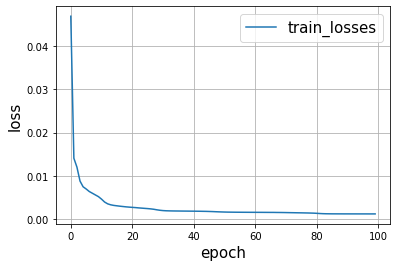

In [8]:
plt.plot(train_losses)
plt.legend(['train_losses'], fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.ylabel('loss', fontsize=15)
plt.grid()

## Inference

In [16]:
Autoencoder = autoencoder(input_size)

#Autoencoder.to(args.device)

Autoencoder.load_state_dict(torch.load('Autoencoder_output' +'.pt'))


autoencoder_feature = Autoencoder.get_encode(input_x.float())

test_autoencoder_feature = Autoencoder.get_encode(test_input_x.float())


In [11]:
print(autoencoder_feature.size())

autoencoder_feature.detach().numpy()

np.save("autoencoder_feature",autoencoder_feature.detach().numpy())

np.save("autoencoder_feature_test",test_autoencoder_feature.detach().numpy())


torch.Size([39607, 26])
